In [2]:
from google.colab import drive
drive.mount('/content/drive')
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

Mounted at /content/drive
TensorFlow 1.x selected.
1.15.2


In [3]:
import pandas as pd
import numpy as np
import datetime
import time
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import math
import random

# read data from csv file and process X, y
def data_loader(data_path):
		# load raw data
		df = pd.read_csv(data_path)

		# clean data with missing values          
		'''drop the rows directly -> mess up the order
			first 24 rows have pm2.5 value that is NaN -> discard
			else: forward filling'''
		df = df[24:].fillna(method='ffill')

		# integrate 'year', 'month', 'day', 'hour', 'No' as one attribute
		df['time'] = df.apply(lambda x : datetime.datetime(year=x['year'], month=x['month'], day=x['day'], hour=x['hour']), axis=1)
		df.drop(columns=['year', 'month', 'day', 'hour', 'No'], inplace=True)
		df = df.set_index('time')

		# expand "cbwd" into 4 attributes 'SE', 'cv', 'NW', 'NE'
		df = df.join(pd.get_dummies(df['cbwd'])) # one-hot encoding
		del df['cbwd']

		# df = df.drop('cbwd', axis = 1) # remove the attribute temporarily

		X = df.iloc[:,1:].astype(np.float32)
		y = df['pm2.5'].astype(np.float32).to_frame()
	
		return X, y
  
# Z-score normalisation
def data_normalisation(train, test):
		X_train, y_train = train[0], train[1]
		X_test, y_test = test[0], test[1]

		mean_x, std_x = X_train.mean(axis=0), X_train.std(axis=0)
		mean_y, std_y = y_train.mean(axis=0), y_train.std(axis=0)
	
		# Use the mean & std of train. Since there's no way for us to know the future.
		# (X_train, y_train) = ((X_train-mean_x)/std_x, (y_train-mean_y)/std_y)
		# (X_val, y_val) = ((X_val-mean_x)/std_x, (y_val-mean_y)/std_y) 
		# (X_test, y_test) = ((X_test-mean_x)/std_x, (y_test-mean_y)/std_y)
		(X_train, y_train) = ((X_train-mean_x)/std_x, np.log(np.asarray(y_train) + 1))
		(X_test, y_test) = ((X_test-mean_x)/std_x, np.log(np.asarray(y_test) + 1))
		# (X_train, y_train) = ((X_train-mean_x)/std_x, y_train)
		# (X_val, y_val) = ((X_val-mean_x)/std_x, y_val) 
		# (X_test, y_test) = ((X_test-mean_x)/std_x, y_test)

		return (X_train, y_train),(X_test, y_test)

data_path = "/content/drive/My Drive/Colab Notebooks/PM2dot5.csv"
X, y = data_loader(data_path)

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.1, shuffle=True)

(X_train, y_train),(X_test, y_test) = data_normalisation((X_train, y_train),(X_test, y_test))

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((39420, 10), (39420, 1), (4380, 10), (4380, 1))

In [4]:
#Network parameters
n_input = 10 
n_hidden1, n_hidden2 = 20, 10
n_output = 1
#Learning parameters 
learning_rate = 0.00005
number_epochs = 20000
batch_size = 128

#Defining the input and the output
X_p = tf.placeholder("float", [None, n_input], name='X_p') 
Y_p = tf.placeholder("float", [None, n_output], name='Y_p')

# forward
def multilayer_perceptron(input_d):
    #DEFINING WEIGHTS AND BIASES
    b1 = tf.Variable(tf.random_normal([n_hidden1])) #Biases first hidden layer
    b2 = tf.Variable(tf.random_normal([n_hidden2])) #Biases second hidden layer
    # b3 = tf.Variable(tf.random_normal([n_hidden3])) #Biases third hidden layer
    # b4 = tf.Variable(tf.random_normal([n_output]))  #Biases output layer
    b3 = tf.Variable(tf.random_normal([n_output]))  #Biases output layer
    
    w1 = tf.Variable(tf.random_normal([n_input, n_hidden1]))   #Weights connecting input layer with first hidden layer
    w2 = tf.Variable(tf.random_normal([n_hidden1, n_hidden2])) #Weights connecting first hidden layer with second hidden layer 
    # w3 = tf.Variable(tf.random_normal([n_hidden2, n_hidden3])) #Weights connecting second hidden layer with third layer
    # w4 = tf.Variable(tf.random_normal([n_hidden3, n_output]))  #Weights connecting third hidden layer with output layer
    w3 = tf.Variable(tf.random_normal([n_hidden2, n_output]))

    layer_1 = tf.nn.leaky_relu(tf.add(tf.matmul(input_d, w1), b1), alpha=0.01) #Task of neurons of first hidden layer
    layer_2 = tf.nn.leaky_relu(tf.add(tf.matmul(layer_1, w2), b2), alpha=0.01) #Task of neurons of second hidden layer
    # layer_3 = tf.nn.relu(tf.add(tf.matmul(layer_2, w3), b3)) #Task of neurons of thrid layer
    out_layer = tf.add(tf.matmul(layer_2, w3),b3)            #Task of neurons of output layer
    
    return out_layer

# create model
neural_network = multilayer_perceptron(X_p)
# define loss function
loss_func = tf.reduce_mean(tf.math.squared_difference(neural_network,Y_p)) # MSE
eval_RMSE = tf.cast(tf.sqrt(loss_func),dtype=tf.float32)
# define optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_func)

# initializaing variables
init = tf.global_variables_initializer()

Epoch: 1000, Training loss: 6.930514, Validation loss: 7.50071, 
Epoch: 2000, Training loss: 4.223196, Validation loss: 4.676659, 
Epoch: 3000, Training loss: 3.8060904, Validation loss: 3.5352182, 
Epoch: 4000, Training loss: 2.5546868, Validation loss: 2.890789, 
Epoch: 5000, Training loss: 1.9068539, Validation loss: 2.4905858, 
Epoch: 6000, Training loss: 2.0558112, Validation loss: 2.212776, 
Epoch: 7000, Training loss: 2.055291, Validation loss: 2.009617, 
Epoch: 8000, Training loss: 1.2955315, Validation loss: 1.8663803, 
Epoch: 9000, Training loss: 2.2493854, Validation loss: 1.7437866, 
Epoch: 10000, Training loss: 2.002606, Validation loss: 1.6502764, 
Epoch: 11000, Training loss: 1.5477648, Validation loss: 1.5709698, 
Epoch: 12000, Training loss: 1.0607119, Validation loss: 1.503752, 
Epoch: 13000, Training loss: 2.0819278, Validation loss: 1.4537972, 
Epoch: 14000, Training loss: 0.9699681, Validation loss: 1.4021066, 
Epoch: 15000, Training loss: 1.295074, Validation loss

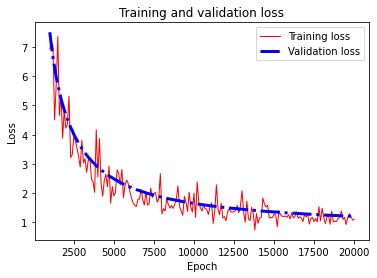

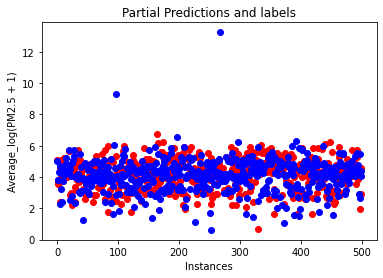

Average RMSE: 1.0622946
Epoch: 1000, Training loss: 1.0310254, Validation loss: 1.0777617, 
Epoch: 2000, Training loss: 1.1065948, Validation loss: 1.0602413, 
Epoch: 3000, Training loss: 1.0970675, Validation loss: 1.0442673, 
Epoch: 4000, Training loss: 0.9322686, Validation loss: 1.02915, 
Epoch: 5000, Training loss: 0.94236445, Validation loss: 1.0162586, 
Epoch: 6000, Training loss: 0.97843295, Validation loss: 1.0026025, 
Epoch: 7000, Training loss: 1.0012299, Validation loss: 0.99159324, 
Epoch: 8000, Training loss: 0.6959174, Validation loss: 0.97954804, 
Epoch: 9000, Training loss: 1.409709, Validation loss: 0.96887374, 
Epoch: 10000, Training loss: 1.2295969, Validation loss: 0.9593268, 
Epoch: 11000, Training loss: 0.9567839, Validation loss: 0.95024323, 
Epoch: 12000, Training loss: 0.7139094, Validation loss: 0.94152284, 
Epoch: 13000, Training loss: 1.3501456, Validation loss: 0.9323449, 
Epoch: 14000, Training loss: 0.69134164, Validation loss: 0.92404634, 
Epoch: 15000,

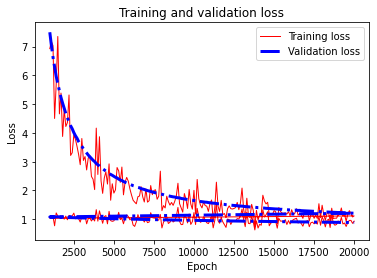

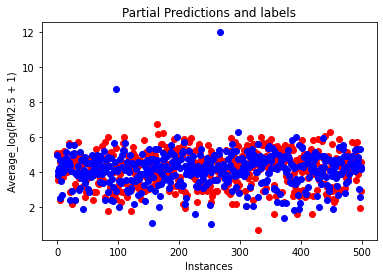

Average RMSE: 0.9563893
Epoch: 1000, Training loss: 0.8647946, Validation loss: 0.86557865, 
Epoch: 2000, Training loss: 0.91185457, Validation loss: 0.8602598, 
Epoch: 3000, Training loss: 0.8708916, Validation loss: 0.85397243, 
Epoch: 4000, Training loss: 0.75455785, Validation loss: 0.848979, 
Epoch: 5000, Training loss: 0.77991116, Validation loss: 0.8440999, 
Epoch: 6000, Training loss: 0.81924653, Validation loss: 0.8390131, 
Epoch: 7000, Training loss: 0.8225644, Validation loss: 0.8351537, 
Epoch: 8000, Training loss: 0.61641157, Validation loss: 0.8294868, 
Epoch: 9000, Training loss: 1.1779712, Validation loss: 0.8253785, 
Epoch: 10000, Training loss: 1.0249662, Validation loss: 0.82103884, 
Epoch: 11000, Training loss: 0.8166524, Validation loss: 0.8175495, 
Epoch: 12000, Training loss: 0.6352619, Validation loss: 0.8137911, 
Epoch: 13000, Training loss: 1.1393838, Validation loss: 0.80897933, 
Epoch: 14000, Training loss: 0.642145, Validation loss: 0.80552715, 
Epoch: 1500

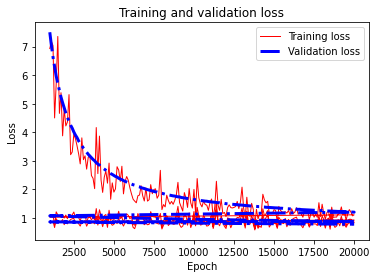

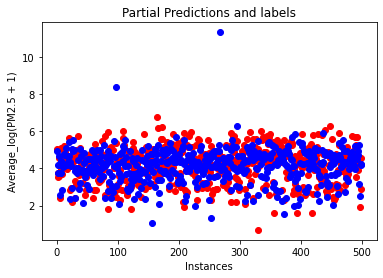

Average RMSE: 0.91087776
Epoch: 1000, Training loss: 0.81370246, Validation loss: 0.82008857, 
Epoch: 2000, Training loss: 0.8228313, Validation loss: 0.8164553, 
Epoch: 3000, Training loss: 0.78074473, Validation loss: 0.81512636, 
Epoch: 4000, Training loss: 0.6916051, Validation loss: 0.8108652, 
Epoch: 5000, Training loss: 0.70030916, Validation loss: 0.80810106, 
Epoch: 6000, Training loss: 0.73977655, Validation loss: 0.8048202, 
Epoch: 7000, Training loss: 0.7493568, Validation loss: 0.8013603, 
Epoch: 8000, Training loss: 0.5781441, Validation loss: 0.8006549, 
Epoch: 9000, Training loss: 1.0575047, Validation loss: 0.7968472, 
Epoch: 10000, Training loss: 0.9342042, Validation loss: 0.7944707, 
Epoch: 11000, Training loss: 0.7451957, Validation loss: 0.7911053, 
Epoch: 12000, Training loss: 0.59833014, Validation loss: 0.7883243, 
Epoch: 13000, Training loss: 1.0309131, Validation loss: 0.7882476, 
Epoch: 14000, Training loss: 0.6230332, Validation loss: 0.78432745, 
Epoch: 15

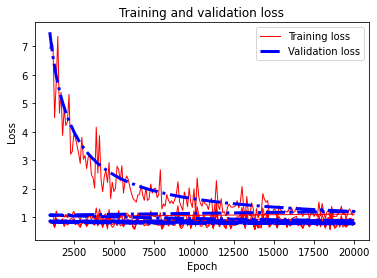

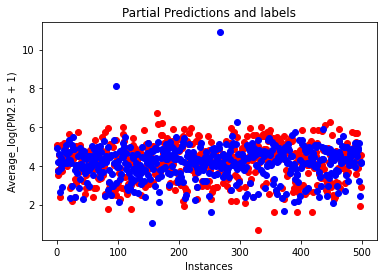

Average RMSE: 0.88410604
Epoch: 1000, Training loss: 0.79557025, Validation loss: 0.7374956, 
Epoch: 2000, Training loss: 0.7710305, Validation loss: 0.7362428, 
Epoch: 3000, Training loss: 0.7360715, Validation loss: 0.7333443, 
Epoch: 4000, Training loss: 0.6583781, Validation loss: 0.7327364, 
Epoch: 5000, Training loss: 0.6592066, Validation loss: 0.7302228, 
Epoch: 6000, Training loss: 0.69952, Validation loss: 0.72899723, 
Epoch: 7000, Training loss: 0.71149683, Validation loss: 0.7278772, 
Epoch: 8000, Training loss: 0.55256367, Validation loss: 0.72510153, 
Epoch: 9000, Training loss: 0.9896752, Validation loss: 0.7246857, 
Epoch: 10000, Training loss: 0.8818905, Validation loss: 0.7222328, 
Epoch: 11000, Training loss: 0.7000688, Validation loss: 0.72125936, 
Epoch: 12000, Training loss: 0.57748866, Validation loss: 0.72016287, 
Epoch: 13000, Training loss: 0.9564029, Validation loss: 0.7176578, 
Epoch: 14000, Training loss: 0.61117274, Validation loss: 0.71686566, 
Epoch: 150

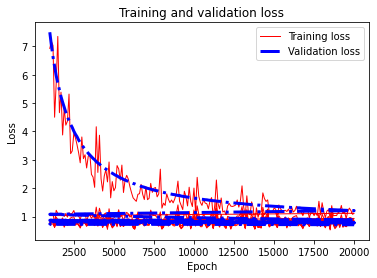

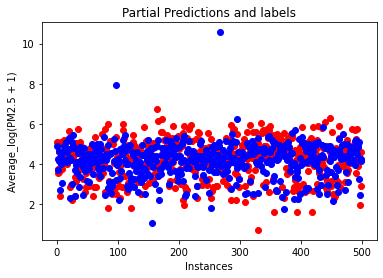

Average RMSE: 0.8659716
Epoch: 1000, Training loss: 0.7829758, Validation loss: 0.69938624, 
Epoch: 2000, Training loss: 0.74106854, Validation loss: 0.6990931, 
Epoch: 3000, Training loss: 0.7039572, Validation loss: 0.6955918, 
Epoch: 4000, Training loss: 0.63820124, Validation loss: 0.6961682, 
Epoch: 5000, Training loss: 0.63191587, Validation loss: 0.6944187, 
Epoch: 6000, Training loss: 0.6800369, Validation loss: 0.69348943, 
Epoch: 7000, Training loss: 0.6895149, Validation loss: 0.6935107, 
Epoch: 8000, Training loss: 0.53284097, Validation loss: 0.69018555, 
Epoch: 9000, Training loss: 0.9425588, Validation loss: 0.6909024, 
Epoch: 10000, Training loss: 0.8462801, Validation loss: 0.68898976, 
Epoch: 11000, Training loss: 0.66278404, Validation loss: 0.68864703, 
Epoch: 12000, Training loss: 0.5629136, Validation loss: 0.6883666, 
Epoch: 13000, Training loss: 0.8970473, Validation loss: 0.6850568, 
Epoch: 14000, Training loss: 0.6033522, Validation loss: 0.68530446, 
Epoch: 1

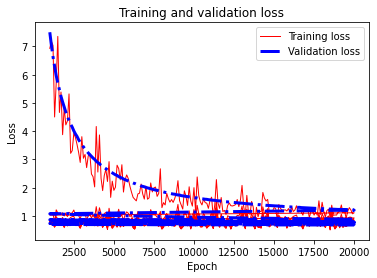

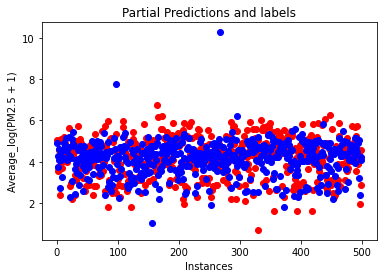

Average RMSE: 0.85252845
Epoch: 1000, Training loss: 0.7728561, Validation loss: 0.6873164, 
Epoch: 2000, Training loss: 0.72367144, Validation loss: 0.6864409, 
Epoch: 3000, Training loss: 0.68252814, Validation loss: 0.6845842, 
Epoch: 4000, Training loss: 0.62654936, Validation loss: 0.68387336, 
Epoch: 5000, Training loss: 0.60926926, Validation loss: 0.68271655, 
Epoch: 6000, Training loss: 0.6681199, Validation loss: 0.681894, 
Epoch: 7000, Training loss: 0.6744206, Validation loss: 0.6809936, 
Epoch: 8000, Training loss: 0.517569, Validation loss: 0.6794083, 
Epoch: 9000, Training loss: 0.905437, Validation loss: 0.6788048, 
Epoch: 10000, Training loss: 0.8220393, Validation loss: 0.67751914, 
Epoch: 11000, Training loss: 0.6341704, Validation loss: 0.67718464, 
Epoch: 12000, Training loss: 0.5508322, Validation loss: 0.67599326, 
Epoch: 13000, Training loss: 0.85017204, Validation loss: 0.6745866, 
Epoch: 14000, Training loss: 0.59825397, Validation loss: 0.6739836, 
Epoch: 150

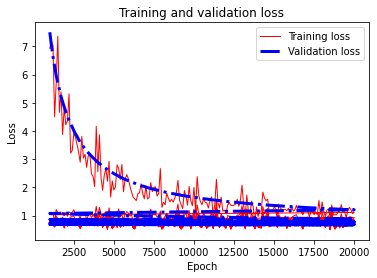

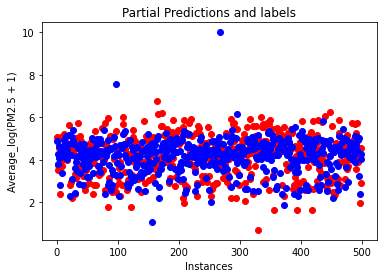

Average RMSE: 0.84218204
Epoch: 1000, Training loss: 0.76562583, Validation loss: 0.67045635, 
Epoch: 2000, Training loss: 0.7122897, Validation loss: 0.6696593, 
Epoch: 3000, Training loss: 0.66557235, Validation loss: 0.6695772, 
Epoch: 4000, Training loss: 0.61686826, Validation loss: 0.6676471, 
Epoch: 5000, Training loss: 0.5935787, Validation loss: 0.6677905, 
Epoch: 6000, Training loss: 0.65756524, Validation loss: 0.66650873, 
Epoch: 7000, Training loss: 0.66402245, Validation loss: 0.66550267, 
Epoch: 8000, Training loss: 0.50649065, Validation loss: 0.6659287, 
Epoch: 9000, Training loss: 0.8741321, Validation loss: 0.66409045, 
Epoch: 10000, Training loss: 0.8066969, Validation loss: 0.664022, 
Epoch: 11000, Training loss: 0.61270183, Validation loss: 0.66327924, 
Epoch: 12000, Training loss: 0.5397512, Validation loss: 0.66187656, 
Epoch: 13000, Training loss: 0.8131908, Validation loss: 0.6626336, 
Epoch: 14000, Training loss: 0.5952828, Validation loss: 0.6609647, 
Epoch:

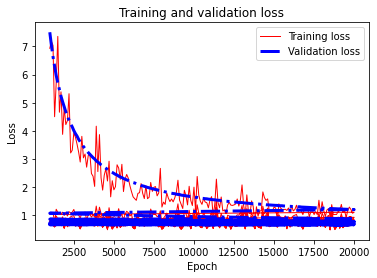

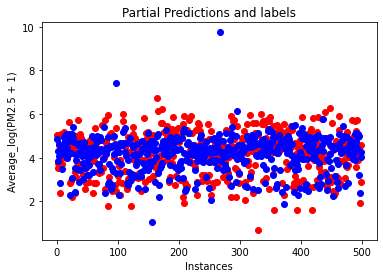

Average RMSE: 0.83363867
Epoch: 1000, Training loss: 0.75953656, Validation loss: 0.6995051, 
Epoch: 2000, Training loss: 0.7034434, Validation loss: 0.6993364, 
Epoch: 3000, Training loss: 0.65157515, Validation loss: 0.697982, 
Epoch: 4000, Training loss: 0.61023796, Validation loss: 0.6980528, 
Epoch: 5000, Training loss: 0.5822872, Validation loss: 0.6970818, 
Epoch: 6000, Training loss: 0.64913, Validation loss: 0.6967121, 
Epoch: 7000, Training loss: 0.65798604, Validation loss: 0.69649345, 
Epoch: 8000, Training loss: 0.49875334, Validation loss: 0.69534755, 
Epoch: 9000, Training loss: 0.846916, Validation loss: 0.6955548, 
Epoch: 10000, Training loss: 0.7955835, Validation loss: 0.6943993, 
Epoch: 11000, Training loss: 0.59558713, Validation loss: 0.6942516, 
Epoch: 12000, Training loss: 0.531435, Validation loss: 0.6939442, 
Epoch: 13000, Training loss: 0.7840414, Validation loss: 0.69294965, 
Epoch: 14000, Training loss: 0.59433097, Validation loss: 0.69266707, 
Epoch: 15000

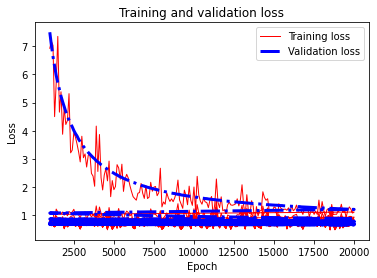

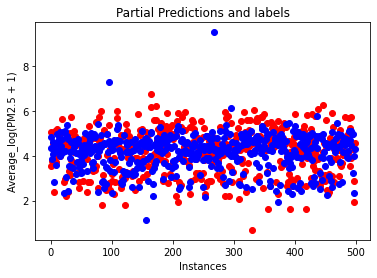

Average RMSE: 0.8266171
Epoch: 1000, Training loss: 0.7544366, Validation loss: 0.6384997, 
Epoch: 2000, Training loss: 0.6958415, Validation loss: 0.6384548, 
Epoch: 3000, Training loss: 0.6402383, Validation loss: 0.63735586, 
Epoch: 4000, Training loss: 0.6052914, Validation loss: 0.6371658, 
Epoch: 5000, Training loss: 0.57418054, Validation loss: 0.6367759, 
Epoch: 6000, Training loss: 0.6416702, Validation loss: 0.63613844, 
Epoch: 7000, Training loss: 0.6523678, Validation loss: 0.6360445, 
Epoch: 8000, Training loss: 0.49275872, Validation loss: 0.63526803, 
Epoch: 9000, Training loss: 0.82432646, Validation loss: 0.63521975, 
Epoch: 10000, Training loss: 0.78707576, Validation loss: 0.63454044, 
Epoch: 11000, Training loss: 0.5819544, Validation loss: 0.63423014, 
Epoch: 12000, Training loss: 0.52608633, Validation loss: 0.6339693, 
Epoch: 13000, Training loss: 0.76079166, Validation loss: 0.6333071, 
Epoch: 14000, Training loss: 0.5936296, Validation loss: 0.63285834, 
Epoch:

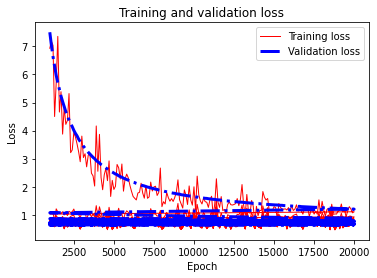

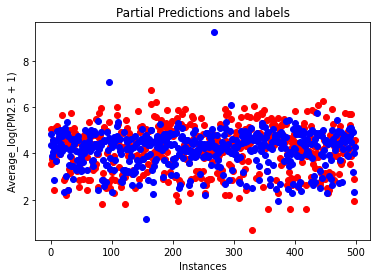

Average RMSE: 0.8209154


In [5]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)

train_x = []
test_x = []
train_y = []
test_y = []
train_losses = []
val_losses = []
select_epoch_from = 1000
epochs = []
batch_iteration = 0
train_losses = []
val_losses = []

with tf.Session() as sess: 
    sess.run(init)
    start_time = time.clock() 
    for train_index, val_index in kf.split(X_train, y_train):
        train_x = X_train[train_index]
        train_y = y_train[train_index]
  
        val_x = X_train[val_index]
        val_y =  y_train[val_index]

        batch_iteration = int(len(train_x) / batch_size) + 1

        for epoch in range(1,number_epochs+1):
          
            n = epoch % batch_iteration
            s = 0 + batch_size * n
            if n == 0:
               e = len(train_x)
            else:
               e = batch_size + batch_size * n
            
            batch_X = np.array(X_train[s:e])
            batch_y = np.array(y_train[s:e])

            _, train_loss = sess.run([optimizer, loss_func], feed_dict={X_p: batch_X, Y_p: batch_y})
            val_loss = loss_func.eval({X_p: val_x, Y_p: val_y})

            if epoch >= select_epoch_from and epoch % 100 == 0:
               train_losses.append(train_loss)
               val_losses.append(val_loss)
               epochs.append(epoch)

            #Display the epoch
            if epoch % 1000 == 0:
               print("Epoch: %d, "
                     "Training loss: %s, "
                     "Validation loss: %s, " % (epoch, train_loss, val_loss))


        end_time = time.clock()
        print("The totoal training time is: " + str(end_time-start_time))

        pyplot.plot(epochs, train_losses, 'r', label='Training loss', linewidth=1, linestyle='-')
        pyplot.plot(epochs, val_losses, 'b', label='Validation loss', linewidth=3, linestyle='-.')
        pyplot.xlabel('Epoch') 
        pyplot.ylabel('Loss')
        pyplot.title('Training and validation loss')
        pyplot.legend()
        pyplot.figure()
    
        # Test model
        pred = (neural_network) 
        output=neural_network.eval({X_p: X_test}) 

        # plot prediction and labels
        pyplot.plot(y_test[0:500], 'ro', label='Testing labels')
        pyplot.plot(output[0:500], 'bo', label='Predictions')
        pyplot.xlabel('Instances') 
        pyplot.ylabel('Average_log(PM2.5 + 1)')
        pyplot.title('Partial Predictions and labels')
        pyplot.show()

        # final RMSE
        rmse_score = sess.run(eval_RMSE,feed_dict={X_p:X_test,Y_p:y_test})
        print("Average RMSE: " + str(rmse_score))
